dogs vs cat

In [1]:
import zipfile, os, shutil, re
from os.path import isfile, isdir
import random
from tqdm import tqdm
import cv2
import numpy as np
import h5py


# extract train.zip image to folder 'train'
if not isdir('train'):
    zipFile = zipfile.ZipFile('train.zip')
    zipFile.extractall()
    zipFile.close()
    
# move cat's image to folder 'train/cat', dog's image to folder 'train/dog'
if not isdir('train/cat'):
    os.mkdir('train/cat')        # create folder train/cat
if not isdir('train/dog'):
    os.mkdir('train/dog')        # create folder train/dog
    
# search files in train folder, check whether it match cat or dog
for filename in os.listdir('train'):
    match_cat = re.search(r'cat.[0-9]*.jpg',filename)
    if match_cat:           # if filename including cat then move to folder train/cat
        shutil.move('train/'+filename, 'train/cat/')   
    
    match_dog = re.search(r'dog.[0-9]*.jpg',filename)
    if match_dog:           # if filename including dog then move to folder train/dog
        shutil.move('train/'+filename, 'train/dog/'+filename)
        
# extract test.zip image to folder 'test'
if not isdir('test'):
    zipFile = zipfile.ZipFile('test.zip')
    zipFile.extractall()
    zipFile.close()
    
if not isdir('test/test'):
    os.mkdir('test/test')        # if not exist test/test then create the sub-folder 'test/test'
    for filename in os.listdir('test'):      # search files in 'test', then move to sub-folder 'test/test'
        if not os.path.isdir(filename):      
            shutil.move('test/'+filename,'test/test/')

C:\Users\thomas_gui\AppData\Local\conda\conda\envs\py36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# remove 
cat_outlier = ['cat.3216.jpg', 'cat.3672.jpg', 'cat.3731.jpg', 'cat.3822.jpg', 'cat.4085.jpg', 'cat.4190.jpg', 'cat.4338.jpg',
               'cat.4688.jpg', 'cat.5351.jpg', 'cat.6277.jpg', 'cat.6402.jpg', 'cat.6649.jpg', 'cat.6840.jpg', 'cat.7377.jpg', 
               'cat.7564.jpg', 'cat.8100.jpg', 'Cat.8272.jpg', 'cat.8456.jpg', 'cat.9171.jpg', 'cat.9513.jpg', 'cat.9770.jpg', 
               'cat.10029.jpg', 'cat.10539.jpg', 'cat.10625.jpg', 'cat.10827.jpg', 'cat.10946.jpg', 'cat.11184.jpg', 
               'cat.12272.jpg', 'cat.12493.jpg', 'cat.12499.jpg']
dog_outlier = ['dog.1043.jpg', 'dog.1094.jpg', 'dog.1259.jpg', 'dog.1308.jpg', 'dog.1835.jpg', 'dog.1895.jpg', 'dog.2877.jpg',
               'dog.3074.jpg','dog.4367.jpg', 'dog.4507.jpg', 'dog.4872.jpg', 'dog.5490.jpg', 'dog.5604.jpg', 'dog.6272.jpg', 
               'dog.6405.jpg', 'dog.6725.jpg', 'dog.7076.jpg', 'dog.7798.jpg', 'dog.7913.jpg', 'dog.8736.jpg', 'dog.9188.jpg', 
               'dog.9517.jpg', 'dog.10190.jpg', 'dog.10237.jpg','dog.10747.jpg','dog.10797.jpg', 'dog.11186.jpg', 
               'dog.11299.jpg', 'dog.12331.jpg', 'dog.12376.jpg']

# print(len(cat_outlier))
# print(len(dog_outlier))
for i in range(30):
    if os.path.isfile('train/cat/'+cat_outlier[i]):
        os.remove('train/cat/'+cat_outlier[i])
    if os.path.isfile('train/dog/'+dog_outlier[i]):
        os.remove('train/dog/'+dog_outlier[i])

cat_list = os.listdir('train/cat')
dog_list = os.listdir('train/dog')
# print(len(cat_list))
# print(len(dog_list))


12470
12470


In [2]:
# define random_transfer function
# used these functions for data argumentation

def random_crop(img, ratio=1.0):
    #随机剪裁, Ratio是裁剪后与裁剪前的面积比
    if random.random() < 1:
        h,w = img.shape[:2]
        #长宽比随机扰动变量 hw_delta
        hw_delta = np.random.uniform(-0.05,0.05)
        hw_mult = 1 + hw_delta
        
        w_crop = int(round(w*np.sqrt(ratio*hw_mult)))
        
        if w_crop > w:
            w_crop = w
        
        h_crop = int(round(h*np.sqrt(ratio/hw_mult)))
        if h_crop > h:
            h_crop = h
        
        x0 = np.random.randint(0,w-w_crop+1)
        y0 = np.random.randint(0,h-h_crop+1)
        
        img = img[y0:y0+h_crop,x0:x0+w_crop]
        
    return img
    
def random_rotate(img, angle=0.0):
    if random.random() < 1:
        h,w = img.shape[:2]
        # angle = np.random.uniform(-angle,angle)
        # angle cycle is 360
        angle %= 360
        # 用openCV 内置函数计算仿射矩阵
        M_rotate = cv2.getRotationMatrix2D((w/2,h/2),angle,1)
        # 得到旋转后的图片
        img = cv2.warpAffine(img, M_rotate, (w, h))
        angle_crop = angle % 180
        
        if angle_crop > 90:
            angle_crop = 180 - angle_crop
        # convert to rad
        theta = angle_crop * np.pi / 180.0
        # compute high width ratio
        hw_ratio = float(h) / float(w)
        
        tan_theta = np.tan(theta)
        numerator = np.cos(theta) + np.sin(theta) * tan_theta
        
        # 计算分母项中的宽高比相关的项
        r = hw_ratio if h > w else 1/hw_ratio
        # 计算分母项
        denominator = r * tan_theta +1
        # 计算最终边长系数
        crop_mult = numerator / denominator
        # 得到剪裁区域
        w_crop = int(round(crop_mult*w))
        h_crop = int(round(crop_mult*h))
        x0 = int((w-w_crop)/2)
        y0 = int((h-h_crop)/2)
        img = img[y0:y0+h_crop,x0:x0+w_crop]
    return img

def random_shear(img,angle=0.0):
    if random.random() < 1:
        h,w = img.shape[:2]
        #产生随机剪切角度值
        # angle = np.random.uniform(-angle,angle)
        # x轴剪切变换，角度值=angle
        theta = angle * np.pi / 180
        M_shear = np.array([[1,np.tan(theta), 0],[0,1,0]],dtype = np.float32)
        img = cv2.warpAffine(img, M_shear, (w, h))
    return img

def random_h_flip(img, horizontal_flip=False):
    if horizontal_flip == True:
        if random.random() < 1:
            img = cv2.flip(img, 1)
    return img
            
def random_v_flip(img, vertical_flip=False):
    if vertical_flip == True:
        if random.random() < 1:
            img = cv2.flip(img,0)
    return img    

def random_transfer(img, ratio=None,rotate=None,shear=None,
                  horizontal_flip=False,vertical_flip=False):
    params = {}
    if ratio is not None:
        params['ratio'] = ratio
    if rotate is not None:
        params['rotate'] = rotate
    if shear is not None:
        params['shear'] = shear
    if horizontal_flip:
        params['horizontal_flip'] = horizontal_flip
    if vertical_flip:
        params['vertical_flip'] = vertical_flip
        
    if params:
        func = []
        for param in params.keys():
            func.append(param)
    func = random.choice(func)
    # print(func,params[func])
    
    function_map = { 'ratio':random_crop,
                     'rotate':random_rotate,
                     'shear':random_shear,
                     'horizontal_flip':random_h_flip,
                     'vertical_flip':random_v_flip
                    }
    
    img_transfer = function_map[func](img,params[func])
    return img_transfer

In [4]:
# random choose a existing image, excute random transfer, replace each outlier image
for i in range(30):
    cat_file = random.choice(cat_list)
    img_cat = cv2.imread('train/cat/'+cat_file)
    img_cat = random_transfer(img_cat, 0.9,10,10,True,True)
    cv2.imwrite('train/cat/'+cat_outlier[i],img_cat)
    
    dog_file = random.choice(dog_list)
    img_dog = cv2.imread('train/dog/'+dog_file)
    img_dog = random_transfer(img_dog, 0.9,10,10,True,True)
    cv2.imwrite('train/dog/'+dog_outlier[i],img_dog)

In [3]:
X_catfile = ['train/cat/cat.%d.jpg' % i for i in range(12500)]
X_dogfile = ['train/dog/dog.%d.jpg' % i for i in range(12500)]
# set the validation split = 0.2
# then split train_set into X_train,X_val, y_train, y_val
splitpoint = int(12500 * 0.8)
# to keep cat and dog file samples balance in train, validation set.
# split 10,000 cat file list into train, 2,500 cat file list into validation
X_catfile_train,X_catfile_val = X_catfile[:splitpoint],X_catfile[splitpoint:]
# split 10,000 dog file list into train, 2,500 dog file list into validation
X_dogfile_train,X_dogfile_val = X_dogfile[:splitpoint],X_dogfile[splitpoint:]
# merge cat and dog train set, total 20,000 file list, first 10,000 is cat file, next 10,000 is dog file
X_train = np.array(X_catfile_train + X_dogfile_train)
# generate train label, first 10,000 is cat file, label = 0 , then next 10,000 label = 1

y_train = np.array([0 for i in range(splitpoint)] + [1 for i in range(splitpoint)])
# same as above operation, merge cat cat and dog validation set, then generate validation label
X_val = np.array(X_catfile_val + X_dogfile_val)
y_val = np.array([0 for i in range(splitpoint,12500)] + [1 for i in range(splitpoint,12500)])

# shuffle train & validation set
# set index for train and validation set
train_idx = np.arange(20000)
val_idx = np.arange(5000)
# set random seed to make sure shuffle result not change everytime
random.seed(2018)
# shuffle train index
random.shuffle(train_idx)

random.seed(2018)
# shuffle validation index
random.shuffle(val_idx)
# re-arrange X_train,y_train by shuffled index
X_train,y_train = X_train[train_idx],y_train[train_idx]
X_val,y_val = X_val[val_idx],y_val[val_idx]
#print(y_train.sum())    #half sample list is cat，another one is dog, so train label sum = 10,000

In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_input
#from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Model
# from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D,Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

batch_size = 50
epochs = 10

# define train_generator function, yield batchs of train and validation data 
def train_generator(X, y, batch_size): 
    
    datalen = len(y)
    counter = datalen//batch_size
    while (True):
        
        for i in range(counter):
            X_299 = np.zeros((batch_size,299,299,3),dtype = np.float)
            for j in range(batch_size):
                X_299[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(299,299))
                
            X_299 = inception_input(X_299)
            yield X_299, y[i * batch_size:(i + 1) * batch_size]

def val_generator(X, y, batch_size):
    
    datalen = len(y)
    counter = datalen//batch_size
    while (True):
        
        for i in range(counter):
            X_299 = np.zeros((batch_size,299,299,3),dtype = np.float)
            for j in range(batch_size):
                X_299[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(299,299))
                
            X_299 = inception_input(X_299)
            yield X_299, y[i * batch_size:(i + 1) * batch_size]

Using TensorFlow backend.


In [5]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model

model_InceptionV3 = InceptionV3(include_top = False, weights = 'imagenet', input_shape=(299,299,3))
for layer in model_InceptionV3.layers:
    layer.trainable = False
model = GlobalAveragePooling2D() (model_InceptionV3.output)

model = Dropout(0.5)(model)
model = Dense(1, activation='sigmoid')(model)
model_InceptionV3_GAP = Model(model_InceptionV3.input,model, name = 'model_InceptionV3')

# plot_model(model_InceptionV3_GAP, to_file='model_InceptionV3_GAP.png',show_shapes = True) 
# SVG(model_to_dot(model_InceptionV3_GAP).create(prog='dot', format='svg'))

model_InceptionV3_GAP.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 35, 35, 256)  0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 35, 35, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 35, 35, 64)   192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 35, 35, 64)   192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 35, 35, 64)   192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 35, 35, 96)   288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 35, 35, 64)   192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 35, 35, 64)   0           batch_normalization_20[0][0]     
__________

batch_normalization_38 (BatchNo (None, 17, 17, 128)  384         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 17, 17, 128)  0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 17, 17, 128)  0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 17, 17, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 17, 17, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_34 

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 17, 17, 192)  576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 17, 17, 192)  576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 17, 17, 192)  576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 17, 17, 192)  576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 17, 17, 192)  0           batch_normalization_41[0][0]     
__________

activation_60 (Activation)      (None, 17, 17, 192)  0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 17, 17, 768)  0           activation_51[0][0]              
                                                                 activation_54[0][0]              
                                                                 activation_59[0][0]              
                                                                 activation_60[0][0]              
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 17, 17, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 17, 17, 192)  576         conv2d_65[0][0]                  
__________

batch_normalization_74 (BatchNo (None, 17, 17, 192)  576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 17, 17, 192)  0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 17, 17, 192)  258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 17, 17, 192)  576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_84 (Activation)      (None, 8, 8, 384)    0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 8, 8, 192)    576         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 8, 8, 320)    0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 8, 8, 768)    0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 8, 8, 768)    0           activation_83[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            2049        dropout_1[0][0]                  
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
___________________________

In [6]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

model_InceptionV3_GAP.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])
model_history = model_InceptionV3_GAP.fit_generator(train_generator(X_train, y_train, batch_size=batch_size),
                                                    steps_per_epoch=len(y_train)//batch_size, epochs=epochs,
                                                    validation_data = val_generator(X_val, y_val, batch_size=batch_size),
                                                    validation_steps=len(y_val)//batch_size,
                                                    callbacks = [earlystop],
                                                    verbose=2)


Epoch 1/10
 - 241s - loss: 0.2116 - acc: 0.9227 - val_loss: 0.0880 - val_acc: 0.9708
Epoch 2/10
 - 241s - loss: 0.1156 - acc: 0.9586 - val_loss: 0.0756 - val_acc: 0.9766
Epoch 3/10
 - 241s - loss: 0.1041 - acc: 0.9593 - val_loss: 0.0728 - val_acc: 0.9778
Epoch 4/10
 - 241s - loss: 0.0985 - acc: 0.9631 - val_loss: 0.0740 - val_acc: 0.9780
Epoch 5/10
 - 241s - loss: 0.0962 - acc: 0.9639 - val_loss: 0.0773 - val_acc: 0.9782
Epoch 6/10
 - 242s - loss: 0.0955 - acc: 0.9623 - val_loss: 0.0931 - val_acc: 0.9720
Epoch 7/10
 - 241s - loss: 0.0935 - acc: 0.9639 - val_loss: 0.0865 - val_acc: 0.9744
Epoch 8/10
 - 241s - loss: 0.0948 - acc: 0.9630 - val_loss: 0.0781 - val_acc: 0.9786


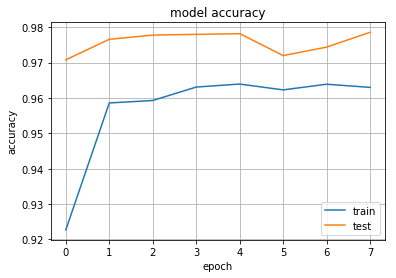

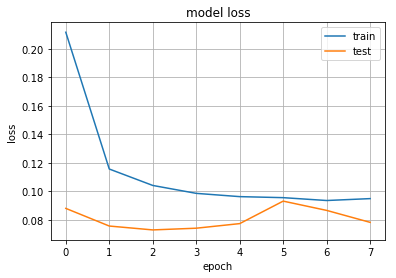

In [7]:
from matplotlib import pyplot as plt  
history=model_history  
# summarize history for accuracy
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='lower right')  
plt.show()  
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='upper right')  
plt.show()  

In [8]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_input

# define train_generator function, yield batchs of train and validation data 
def train_gen_224(X, y, batch_size): 
    
    datalen = len(y)
    counter = datalen//batch_size
    while (True):
        
        for i in range(counter):
            X_224 = np.zeros((batch_size,224,224,3),dtype = np.float)
            for j in range(batch_size):
                X_224[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(224,224))
                
            X_224 = resnet_input(X_224)
            yield X_224, y[i * batch_size:(i + 1) * batch_size]

def val_gen_224(X, y, batch_size):
    
    datalen = len(y)
    counter = datalen//batch_size
    while (True):
        
        for i in range(counter):
            X_224 = np.zeros((batch_size,224,224,3),dtype = np.float)
            for j in range(batch_size):
                X_224[j] = cv2.resize(cv2.imread(X[i* batch_size+j]),(224,224))
                
            X_224 = resnet_input(X_224)
            yield X_224, y[i * batch_size:(i + 1) * batch_size]

In [9]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3),pooling='avg')
for layer in base_model.layers:
    layer.trainable = False
x = Dropout(0.5)(base_model.output)
x = Dense(1, activation='sigmoid')(x)
model_ResNet50 = Model(inputs = base_model.input, outputs=x, name = 'model_ResNet50')
model_ResNet50.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

res3a_branch2a (Conv2D)         (None, 28, 28, 128)  32896       activation_104[0][0]             
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_105 (Activation)     (None, 28, 28, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 28, 28, 128)  147584      activation_105[0][0]             
__________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizati (None, 28, 28, 128)  512         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
add_7 (Add)                     (None, 28, 28, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_113[0][0]             
__________________________________________________________________________________________________
activation_116 (Activation)     (None, 28, 28, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 14, 14, 256)  131328      activation_116[0][0]             
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 14, 14, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_127 (Activation)     (None, 14, 14, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 14, 14, 1024) 263168      activation_127[0][0]             
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 14, 14, 1024) 4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_11 (Add)                    (None, 14, 14, 1024) 0           bn4d_branch2c[0][0]              
                                                                 activation_125[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_138 (Activation)     (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_138[0][0]             
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_139 (Activation)     (None, 7, 7, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 7, 7, 2048)   1050624     activation_139[0][0]             
__________

In [10]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

model_ResNet50.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])
model_ResNet50_history = model_ResNet50.fit_generator(train_gen_224(X_train, y_train, batch_size=batch_size),
                                                    steps_per_epoch=len(y_train)//batch_size, epochs=epochs,
                                                    validation_data = val_gen_224(X_val, y_val, batch_size=batch_size),
                                                    validation_steps=len(y_val)//batch_size,
                                                    callbacks = [earlystop],
                                                    verbose=2)

Epoch 1/10
 - 177s - loss: 0.1564 - acc: 0.9384 - val_loss: 0.0965 - val_acc: 0.9642
Epoch 2/10
 - 178s - loss: 0.0934 - acc: 0.9640 - val_loss: 0.0677 - val_acc: 0.9748
Epoch 3/10
 - 178s - loss: 0.0859 - acc: 0.9671 - val_loss: 0.0883 - val_acc: 0.9696
Epoch 4/10
 - 178s - loss: 0.0791 - acc: 0.9678 - val_loss: 0.0925 - val_acc: 0.9700
Epoch 5/10
 - 178s - loss: 0.0790 - acc: 0.9698 - val_loss: 0.0824 - val_acc: 0.9726
Epoch 6/10
 - 179s - loss: 0.0791 - acc: 0.9690 - val_loss: 0.0756 - val_acc: 0.9744
Epoch 7/10
 - 178s - loss: 0.0772 - acc: 0.9698 - val_loss: 0.0867 - val_acc: 0.9724


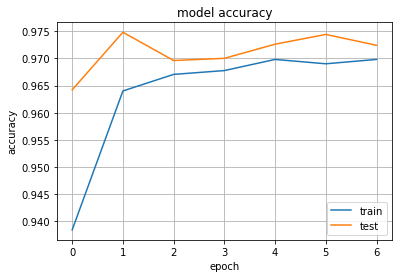

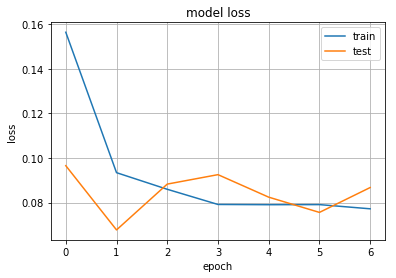

In [11]:
from matplotlib import pyplot as plt  
history=model_ResNet50_history  
# summarize history for accuracy
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='lower right')  
plt.show()  
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='upper right')  
plt.show()  

In [12]:
from keras.applications.xception import Xception
base_model = Xception(include_top=False, weights='imagenet', input_shape=(299,299,3),pooling='avg')
for layer in base_model.layers:
    layer.trainable = False
x = Dropout(0.5)(base_model.output)
x = Dense(1, activation='sigmoid')(x)
model_Xception = Model(inputs = base_model.input, outputs=x, name = 'model_Xception')
model_Xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block5_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 19, 19, 728)  0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 19, 19, 728)  536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 19, 19, 728)  2912        block5_sepconv2[0][0]            
__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, 19, 19, 728)  0           block5_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
block5_sep

block9_sepconv1 (SeparableConv2 (None, 19, 19, 728)  536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 19, 19, 728)  0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 19, 19, 728)  536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 19, 19, 728)  2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

block13_sepconv1_act (Activatio (None, 19, 19, 728)  0           add_27[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1 (SeparableConv (None, 19, 19, 728)  536536      block13_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block13_sepconv1_bn (BatchNorma (None, 19, 19, 728)  2912        block13_sepconv1[0][0]           
__________________________________________________________________________________________________
block13_sepconv2_act (Activatio (None, 19, 19, 728)  0           block13_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block13_sepconv2 (SeparableConv (None, 19, 19, 1024) 752024      block13_sepconv2_act[0][0]       
__________________________________________________________________________________________________
block13_se

In [13]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

model_Xception.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics =['accuracy'])
model_Xception_history = model_Xception.fit_generator(train_generator(X_train, y_train, batch_size=batch_size),
                                                    steps_per_epoch=len(y_train)//batch_size, epochs=epochs,
                                                    validation_data = val_generator(X_val, y_val, batch_size=batch_size),
                                                    validation_steps=len(y_val)//batch_size,
                                                    callbacks = [earlystop],
                                                    verbose=2)

Epoch 1/10
 - 367s - loss: 0.1364 - acc: 0.9652 - val_loss: 0.0960 - val_acc: 0.9728
Epoch 2/10
 - 369s - loss: 0.0624 - acc: 0.9805 - val_loss: 0.0787 - val_acc: 0.9772
Epoch 3/10
 - 369s - loss: 0.0534 - acc: 0.9822 - val_loss: 0.0804 - val_acc: 0.9760
Epoch 4/10
 - 369s - loss: 0.0500 - acc: 0.9836 - val_loss: 0.0760 - val_acc: 0.9768
Epoch 5/10
 - 369s - loss: 0.0476 - acc: 0.9844 - val_loss: 0.0692 - val_acc: 0.9798
Epoch 6/10
 - 367s - loss: 0.0469 - acc: 0.9828 - val_loss: 0.0771 - val_acc: 0.9766
Epoch 7/10
 - 365s - loss: 0.0452 - acc: 0.9831 - val_loss: 0.0804 - val_acc: 0.9754
Epoch 8/10
 - 364s - loss: 0.0447 - acc: 0.9839 - val_loss: 0.0723 - val_acc: 0.9784
Epoch 9/10
 - 367s - loss: 0.0443 - acc: 0.9859 - val_loss: 0.0765 - val_acc: 0.9770
Epoch 10/10
 - 366s - loss: 0.0427 - acc: 0.9850 - val_loss: 0.0771 - val_acc: 0.9770


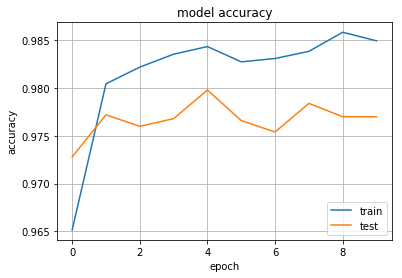

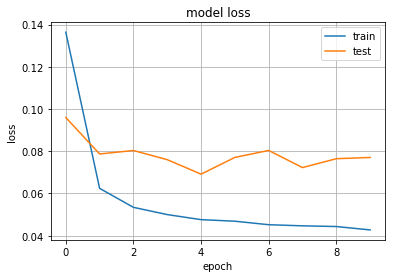

In [14]:
from matplotlib import pyplot as plt  
history=model_Xception_history  
# summarize history for accuracy
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='lower right')  
plt.show()  
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(['train', 'test'], loc='upper right')  
plt.show()  

In [ ]:
# test generator
n_test = 12500
X_test = np.zeros((n_test,299,299,3),dtype=np.uint8)
for i in tqdm(range(12500)):
    j = i+1
    X_test[i] = cv2.resize(cv2.imread('test/test/%d.jpg' % j), (299,299))
    
def test_generator(X, batch_size): 
    datalen = len(X)
    counter = datalen//batch_size
    while (True):
        for i in range(counter):
            yield (X[i * batch_size:(i + 1) * batch_size]-127.5)/127.5


In [ ]:
# make prediction
# clip log-loss results to range(0.005,0.995)
predictions = model_InceptionV3_GAP.predict_generator(test_generator(X_test,100),steps=125, verbose=1)
predictions = predictions.clip(min=0.005,max=0.995)
output = pd.read_csv('sample_submission.csv')
print(len(predictions))
output.label = predictions
output.to_csv('InceptionV3_predictions.csv',index=None)